In [1]:
import numpy as np
import scipy as sp
import scgeom as sg
import scanpy as sc
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr, ranksums

import matplotlib as mpl
plt.rcParams["font.family"] = "arial"
mpl.rcParams['font.size'] = 14

In [2]:
adata = sc.read('./data/ipsc.h5ad')

In [3]:
sc.pp.pca(adata)

In [4]:
sc.pp.neighbors(adata,metric = 'euclidean',n_neighbors=50, use_rep='X_pca', n_pcs=10)
sc.tl.umap(adata, random_state=1)
X_umap = adata.obsm['X_umap']

In [5]:
sc.tl.leiden(adata,resolution = 1.75)

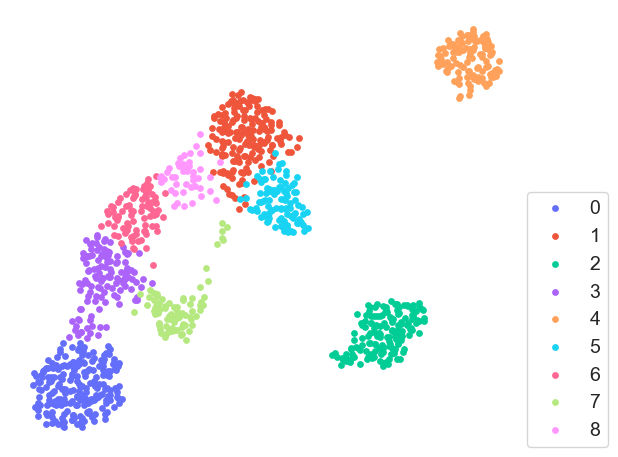

In [6]:
import plotly
colors = plotly.colors.qualitative.Plotly
celltypes = np.sort(list(set(adata.obs['leiden'])))
celltype_vec = adata.obs['leiden']
cnt = 0
for celltype in celltypes:
    idx = np.where(celltype_vec == celltype)[0]
    plt.scatter(X_umap[idx,0], X_umap[idx,1], c=colors[cnt], label=celltype, s=15)
    cnt += 1
plt.axis('equal')
plt.axis('off')
plt.grid(False)
plt.legend(loc=[1.01,0])
plt.tight_layout()

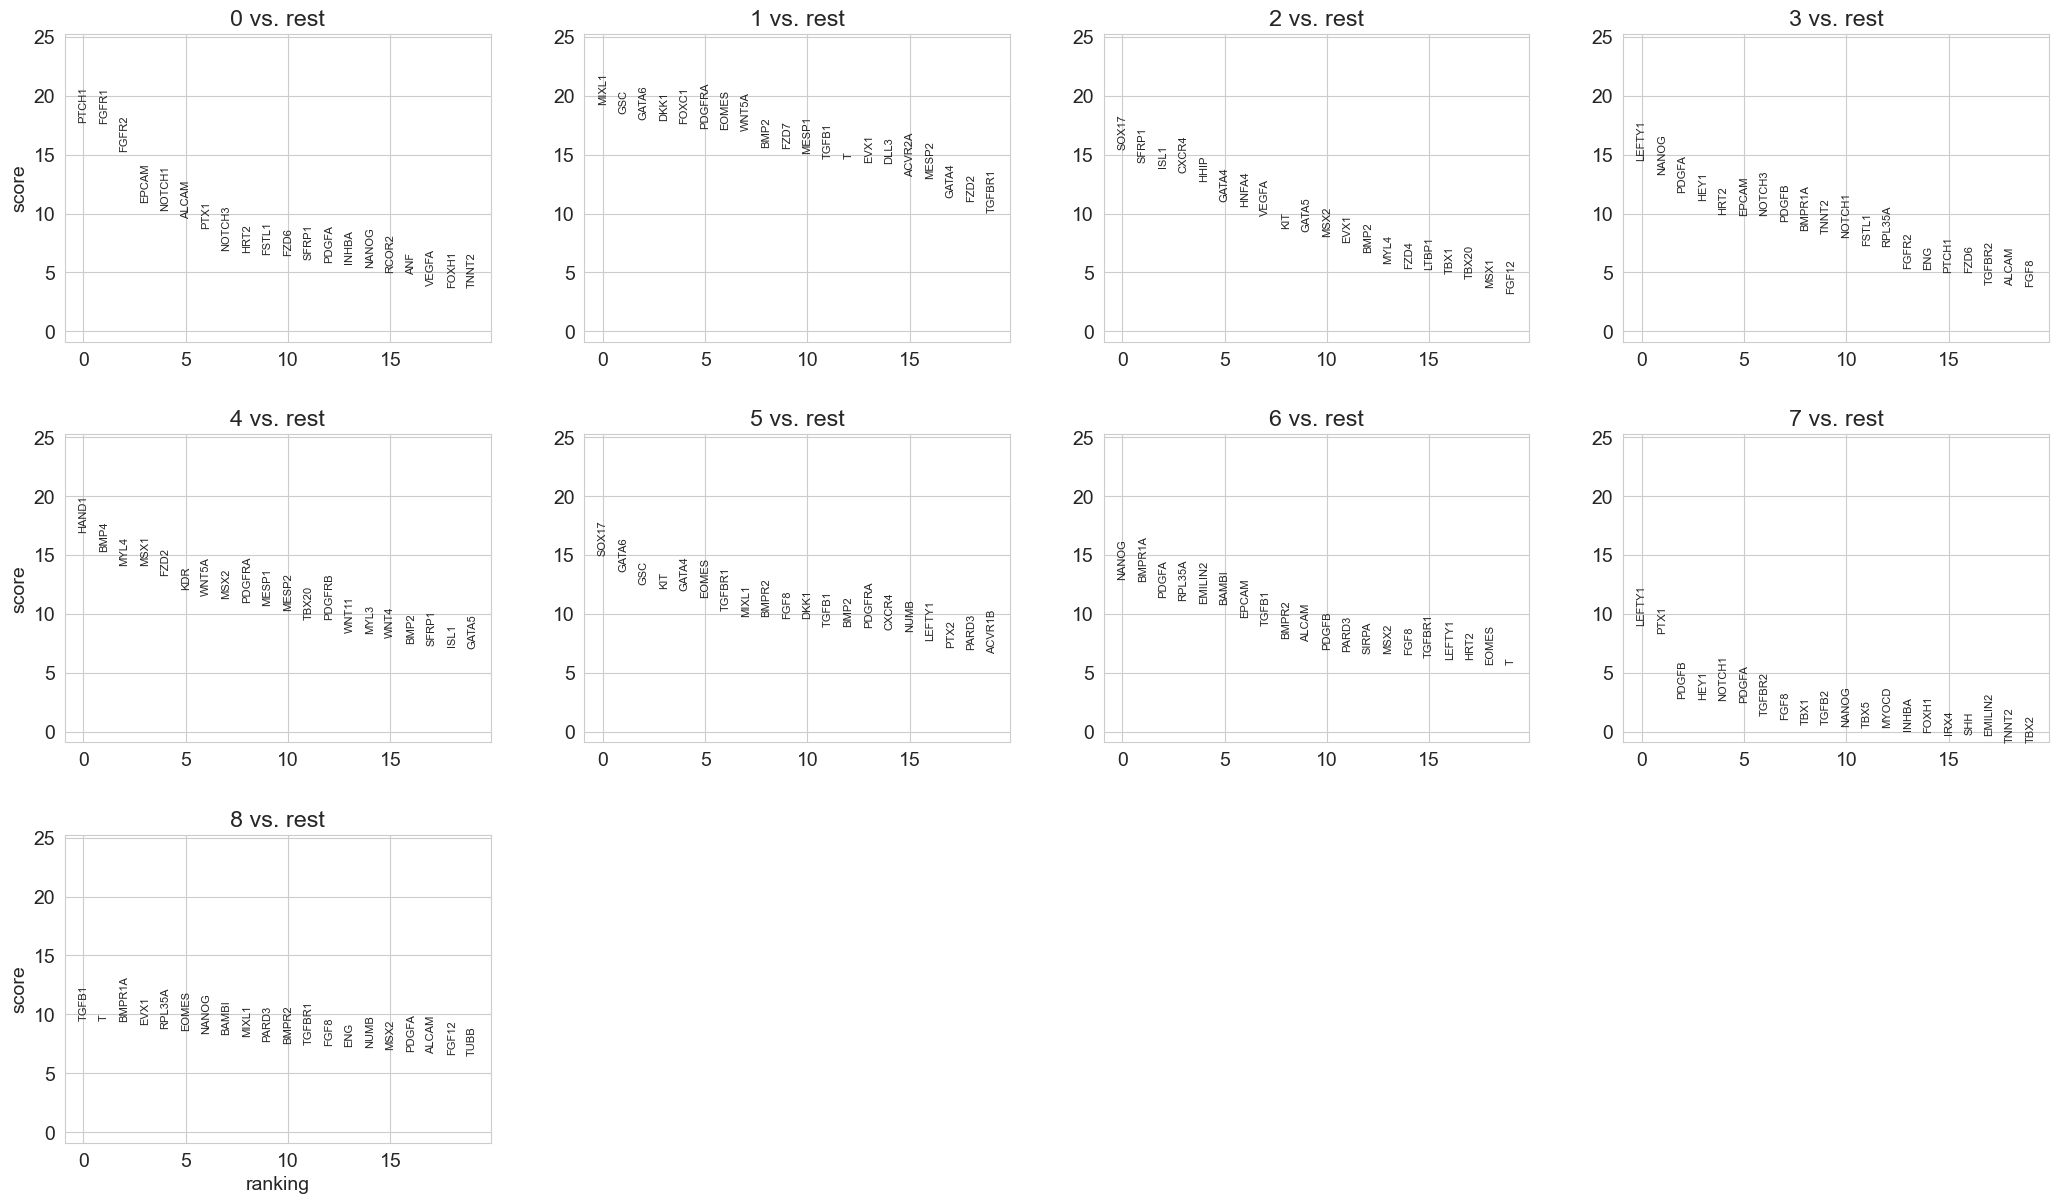

In [7]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata)

In [8]:
sc.pp.pca(adata)
X_pca = np.array( adata.obsm['X_pca'] )
X_umap = np.array( adata.obsm['X_umap'] )

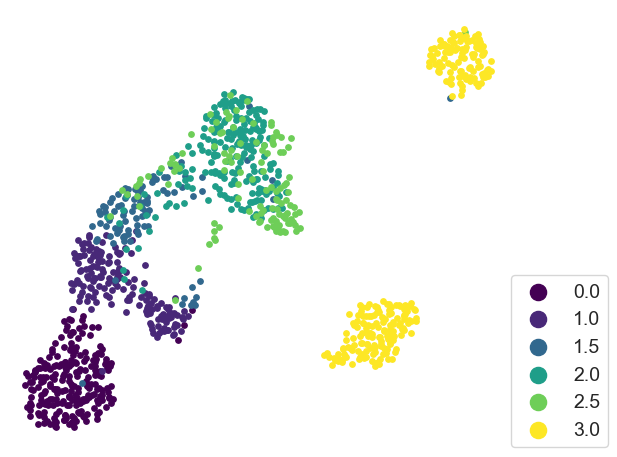

In [9]:
import plotly.express as px
colors = np.array(px.colors.sequential.Viridis)[np.array([0,1,3,5,7,9])]
times = np.array( adata.obs['time'] )
unique_times = np.sort(list(set(times)))
for i in range(len(unique_times)):
    idx = np.where(times == unique_times[i])[0]
    plt.scatter(X_umap[idx,0], X_umap[idx,1], c=colors[i], label=unique_times[i], s=15)
plt.legend(loc=[1.01,0], markerscale=3)
plt.axis('off')
plt.axis('equal')
plt.grid(False)
plt.tight_layout()

In [10]:
D = distance_matrix(X_pca[:,:20], X_pca[:,:20])
sg.tl.neighbor_graph(adata, D=D, knn_k=80, weighted=False, graph_name='curvature_graph')

In [11]:
sg.tl.graph_curvature(adata, curvature_method='orc', orc_alpha=0.5, graph_name='curvature_graph')

(-6.385383296012878, 12.324489760398865, 2.1281673550605773, 18.11997035741806)

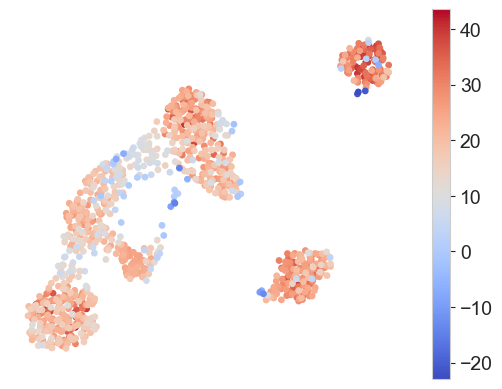

In [12]:
c = adata.obs['scgeom-node_curvature']
idx = np.argsort(-c)
plt.scatter(X_umap[idx,0], X_umap[idx,1], c=c[idx], cmap='coolwarm', s=15)
plt.colorbar()
plt.axis('equal')
plt.grid(False)
plt.axis('off')

In [13]:
adata.obsm['X_pca'] = adata.obsm['X_pca'][:,:20]
sg.tl.cell_network_topology(adata, network_name = 'connectivities', embedding_name = 'X_pca', nb_method = 'knn',
        nb_knn=100, max_filtration = 15, max_dim=1, method = 'lwph', uns_name='diagrams_cell_network_lwph')

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
Done


In [14]:
sg.tl.generate_topology_feature(adata, method='tp', diagram_name='diagrams_cell_network_lwph', feature_name='X_topo_tp',
    inf_value = 'replace_max', dims=[0,1])

In [15]:
sg.tl.generate_topology_feature(adata, method='pe', diagram_name='diagrams_cell_network_lwph', feature_name='X_topo_pe',
    inf_value = 'replace_max', dims=[0,1])

#### **H0 total persistence of local weighted persistent homology (lwph) of cell network**

(-6.385383296012878, 12.324489760398865, 2.1281673550605773, 18.11997035741806)

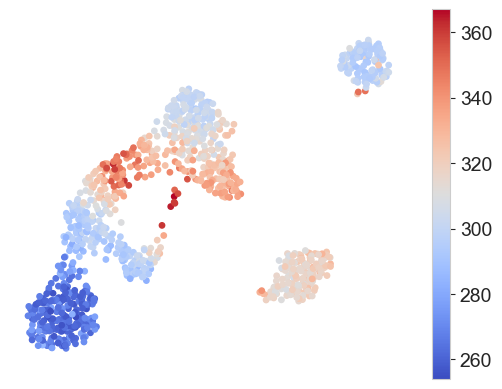

In [16]:
plt.scatter(X_umap[:,0], X_umap[:,1], c=adata.obsm['X_topo_tp'][:,0], cmap='coolwarm', s=15)
plt.colorbar()
plt.grid(False)
plt.axis('equal')
plt.axis('off')

In [17]:
times_str = np.array(times, str)

In [18]:
df_ipsc = pd.DataFrame({'time': times_str, 'curvature': adata.obs['scgeom-node_curvature'],
    'lwph_h0_tp': adata.obsm['X_topo_tp'][:,0], 'lwph_h1_tp': adata.obsm['X_topo_tp'][:,1],
    'lwph_h0_pe': adata.obsm['X_topo_pe'][:,0], 'lwph_h1_pe': adata.obsm['X_topo_pe'][:,1]})

In [19]:
x_h0_tp = adata.obsm['X_topo_tp'][:,0]
x_h1_tp = adata.obsm['X_topo_tp'][:,1]
x_h0_pe = adata.obsm['X_topo_pe'][:,0]
x_h1_pe = adata.obsm['X_topo_pe'][:,1]
x_curvature = adata.obs['scgeom-node_curvature']
xx = x_h0_tp.copy()
for i in range(len(unique_times)-1):
    idx_i = np.where(times==unique_times[i])[0]
    idx_ip1 = np.where(times==unique_times[i+1])[0]
    xi = xx[idx_i]
    xip1 = xx[idx_ip1]
    print(unique_times[i], unique_times[i+1], ranksums(xi,xip1))

0.0 1.0 RanksumsResult(statistic=-16.656246236925785, pvalue=2.7260595470031884e-62)
1.0 1.5 RanksumsResult(statistic=-12.881448557604479, pvalue=5.725083671499813e-38)
1.5 2.0 RanksumsResult(statistic=7.651263472606095, pvalue=1.9901410203478054e-14)
2.0 2.5 RanksumsResult(statistic=-7.5207799334856436, pvalue=5.445043454930249e-14)
2.5 3.0 RanksumsResult(statistic=10.154234638930808, pvalue=3.1728987436749095e-24)


In [20]:
x_h0_tp = adata.obsm['X_topo_tp'][:,0]
x_h1_tp = adata.obsm['X_topo_tp'][:,1]
x_h0_pe = adata.obsm['X_topo_pe'][:,0]
x_h1_pe = adata.obsm['X_topo_pe'][:,1]
x_curvature = adata.obs['scgeom-node_curvature']
xx = x_curvature.copy()
for i in range(len(unique_times)-1):
    idx_i = np.where(times==unique_times[i])[0]
    idx_ip1 = np.where(times==unique_times[i+1])[0]
    xi = xx[idx_i]
    xip1 = xx[idx_ip1]
    print(unique_times[i], unique_times[i+1], ranksums(xi,xip1))

0.0 1.0 RanksumsResult(statistic=0.43449535009016366, pvalue=0.6639287707150952)
1.0 1.5 RanksumsResult(statistic=7.8222380234366, pvalue=5.189236934507952e-15)
1.5 2.0 RanksumsResult(statistic=-7.93304406500891, pvalue=2.138385142449682e-15)
2.0 2.5 RanksumsResult(statistic=7.076574269805059, pvalue=1.4776157910649583e-12)
2.5 3.0 RanksumsResult(statistic=-11.903791961705902, pvalue=1.1308915649033523e-32)


In [23]:
import plotly
import plotly.graph_objects as go
xx = x_curvature.copy()
x_data = ['d0','d1','d1.5','d2','d2.5','d3']
y_data = []
for i in range(len(unique_times)):
    tmp_idx = np.where(times==unique_times[i])[0]
    y_data.append(xx[tmp_idx])
colors = list( np.array(px.colors.sequential.Viridis)[np.array([0,1,3,5,7,9])] )

fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.2,
            whiskerwidth=0.5,
            fillcolor=cls,
            marker={'color':cls},
            line={'color':'#444'},
            marker_size=2,
            line_width=1)
        )

fig.update_layout(
    title="curvature",
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=10,
        gridcolor='rgb(240, 240, 240)',
        gridwidth=1,
        zerolinecolor='rgb(240, 240, 240)',
        zerolinewidth=1.2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=50,
    ),
    width = 600,
    height = 500,
    font=dict(
        family="Arial",
        size=20,
        color="black"
    ),
    paper_bgcolor='rgb(255, 255, 255)',
    plot_bgcolor='rgb(255, 255, 255)',
    showlegend=False
)

fig.show()
fig.write_image("./boxplot_curvature.pdf")

In [22]:
import plotly
import plotly.graph_objects as go
xx = x_h0_tp.copy()
x_data = ['d0','d1','d1.5','d2','d2.5','d3']
y_data = []
for i in range(len(unique_times)):
    tmp_idx = np.where(times==unique_times[i])[0]
    y_data.append(xx[tmp_idx])
colors = list( np.array(px.colors.sequential.Viridis)[np.array([0,1,3,5,7,9])] )

fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.2,
            whiskerwidth=0.5,
            fillcolor=cls,
            marker={'color':cls},
            line={'color':'#444'},
            marker_size=2,
            line_width=1)
        )

fig.update_layout(
    title="H0 total persistence",
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=10,
        gridcolor='rgb(240, 240, 240)',
        gridwidth=1,
        zerolinecolor='rgb(240, 240, 240)',
        zerolinewidth=1.2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=50,
    ),
    width = 600,
    height = 500,
    font=dict(
        family="Arial",
        size=20,
        color="black"
    ),
    paper_bgcolor='rgb(255, 255, 255)',
    plot_bgcolor='rgb(255, 255, 255)',
    showlegend=False
)

fig.show()
fig.write_image("./boxplot_lwph_h0_tp.pdf")